# Visualization Story: Geometry, Loss, and Dimension

**Name:**  
**Date:**

In this notebook you will explore how prediction behaves through geometry, loss functions, and dimensionality using the California Housing dataset.

Your goal is to build a short visualization story supported by figures.

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import pairwise_distances

np.random.seed(0)

## Task 1: Meet the Data

**What does this dataset describe?**
The dataset describes California housing districts (from the 1990 census). Each row represents a census block group (district), not an individual house. The target variable is the median house value for that district.

**What does the response variable look like?**
The response variable (`MedHouseVal`) has a **right-skewed distribution** (tail to the right) with a mean of ~2.07 and a median of ~1.80 ($100k). It is capped at 5.0.

**Are there visible patterns or surprises?**
- **Capping**: There is a large spike at the maximum value of 5.0 ($500,000), indicating that values strictly above this threshold were censored/capped.
- **Geography**: House values are clearly higher along the coast and in the bay area compared to the inland valley.
- **Income Correlation**: Median Income is strongly positively correlated with Median House Value.


In [2]:
# Load the dataset
data = fetch_california_housing()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name="HouseValue")

# Print shape and first few rows
print("Shape:", X.shape)
print(X.head())

Shape: (20640, 8)
   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  
0    -122.23  
1    -122.22  
2    -122.24  
3    -122.25  
4    -122.25  


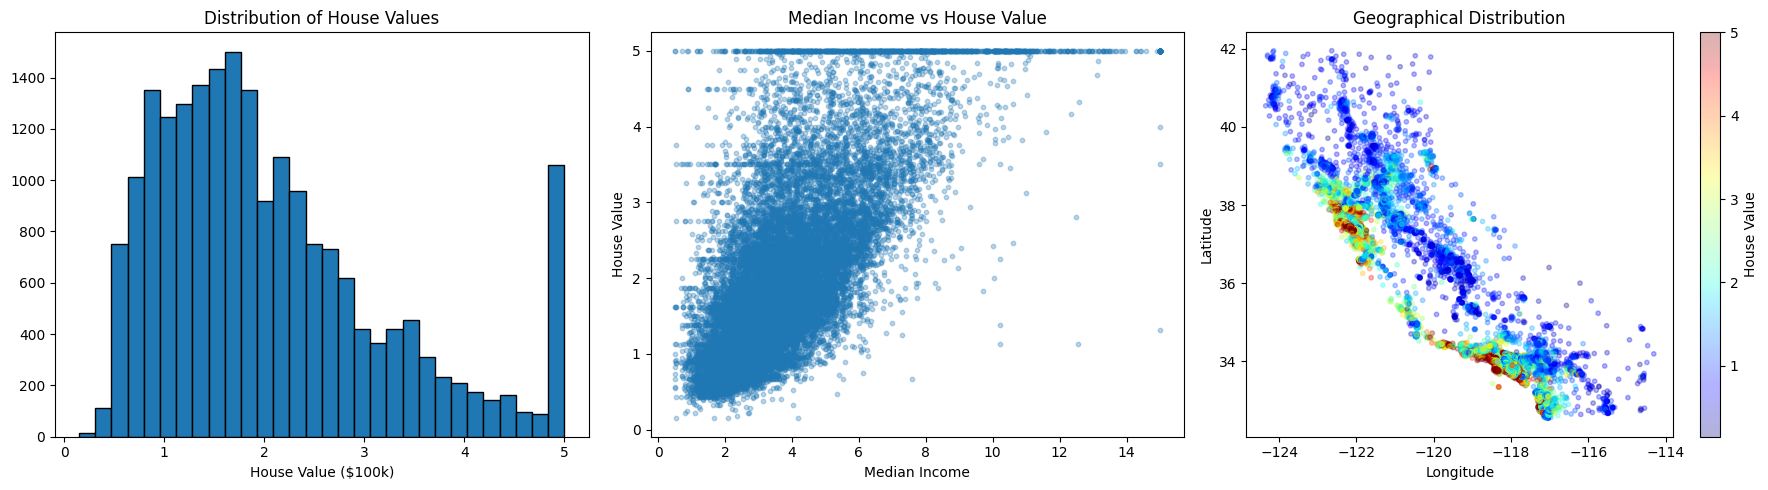

In [3]:
# Create 2–3 exploratory plots
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.hist(y, bins=30, edgecolor='k')
plt.title('Distribution of House Values')
plt.xlabel('House Value ($100k)')

plt.subplot(1, 3, 2)
plt.scatter(X['MedInc'], y, alpha=0.3, s=10)
plt.title('Median Income vs House Value')
plt.xlabel('Median Income')
plt.ylabel('House Value')

plt.subplot(1, 3, 3)
sc = plt.scatter(X['Longitude'], X['Latitude'], c=y, cmap='jet', alpha=0.3, s=10)
plt.colorbar(sc, label='House Value')
plt.title('Geographical Distribution')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.tight_layout()
plt.savefig('task1_exploratory.png')
plt.show()

## Task 2: Two Ways to Draw a Shape Through Data

**How does each method "see" the data?**
- **Linear Regression**: "Sees" the global trend. It assumes a rigid, smooth linear relationship (a straight line or plane) across the entire dataset. It minimizes the global sum of squared errors.
- **kNN (k-Nearest Neighbors)**: "Sees" local neighborhoods. It assumes that similar inputs have similar outputs. It adapts to local variations by averaging the values of the $k$ closest points.

**Where do they agree, and where do they differ?**
- **Agreement**: Both capture the general positive trend (e.g., as Income increases, Price increases).
- **Difference**: Linear regression produces a smooth, straight line that underfits complex wiggles. kNN produces a jagged or "step-like" prediction line that attempts to follow the local data density.

**Which one seems more sensitive to local patterns?**
**kNN** is much more sensitive to local patterns. With a lower $k$ (e.g., $k=10$), it reacts to local clusters and noise, whereas Linear Regression ignores them in favor of the global trend.


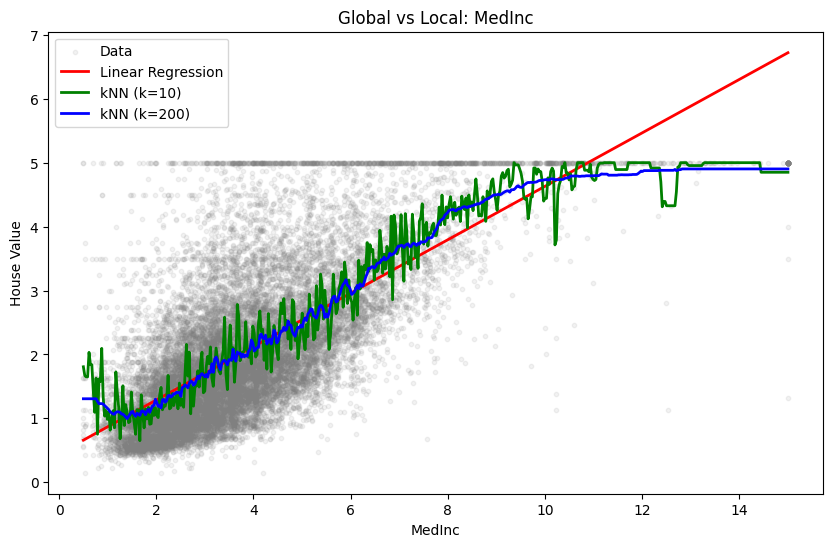

In [4]:
# Select one feature (e.g., MedInc)
feature = 'MedInc'
X1 = X[[feature]].values
y1 = y.values

# Fit models
ls = LinearRegression()
ls.fit(X1, y1)

knn1 = KNeighborsRegressor(n_neighbors=10)
knn1.fit(X1, y1)

knn2 = KNeighborsRegressor(n_neighbors=200)
knn2.fit(X1, y1)

# Fit and plot predictions
X_grid = np.linspace(X1.min(), X1.max(), 500).reshape(-1, 1)

pred_ls = ls.predict(X_grid)
pred_knn1 = knn1.predict(X_grid)
pred_knn2 = knn2.predict(X_grid)

plt.figure(figsize=(10, 6))
plt.scatter(X1, y1, color='gray', alpha=0.1, label='Data', s=10)
plt.plot(X_grid, pred_ls, 'r-', label='Linear Regression', linewidth=2)
plt.plot(X_grid, pred_knn1, 'g-', label='kNN (k=10)', linewidth=2)
plt.plot(X_grid, pred_knn2, 'b-', label='kNN (k=200)', linewidth=2)
plt.legend()
plt.xlabel(feature)
plt.ylabel('House Value')
plt.title(f'Global vs Local: {feature}')
plt.savefig('task2_global_vs_local.png')
plt.show()

## Task 3: What Does It Mean to Predict Well?

**The mean and the median of the response:**
For the skewed subset (values > 3.0 or top 20%):
- **Mean**: ~4.04 (Pulled higher by the skew/outliers)
- **Median**: ~3.88 (More robust, closer to the dense cluster)

**Squared loss and absolute loss:**
- **Squared Loss**: Penalizes large errors quadratically ($error^2$). It is highly sensitive to outliers.
- **Absolute Loss**: Penalizes errors linearly ($|error|$). It is robust to outliers.

**Which prediction each loss prefers:**
- **Squared Loss prefers the MEAN**. The mean minimizes the sum of squared errors.
- **Absolute Loss prefers the MEDIAN**. The median minimizes the sum of absolute errors.


In [ ]:
# Choose a skewed subset of y
subset = y[y > 3.0]
if len(subset) < 100:
   subset = y[y > y.quantile(0.8)]

# Plot histogram and mark mean and median
mean_val = np.mean(subset)
median_val = np.median(subset)

plt.figure(figsize=(8, 5))
plt.hist(subset, bins=30, color='skyblue', edgecolor='k', alpha=0.7, label='Data')
plt.axvline(mean_val, color='r', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
plt.axvline(median_val, color='g', linestyle='-', linewidth=2, label=f'Median: {median_val:.2f}')
plt.legend()
plt.title('Distribution of Skewed Subset')
plt.show()

In [ ]:
# Compute and plot squared loss and absolute loss risk curves
a_vals = np.linspace(subset.min() * 0.9, subset.max() * 1.1, 200)
sq_loss = [np.mean((subset - a)**2) for a in a_vals]
abs_loss = [np.mean(np.abs(subset - a)) for a in a_vals]

# Plot
plt.figure(figsize=(10, 5))
plt.plot(a_vals, sq_loss, 'r-', label='Squared Error Risk')
plt.plot(a_vals, abs_loss, 'g-', label='Absolute Error Risk')

# Mark minima
plt.plot(mean_val, np.min(sq_loss), 'ro')
plt.plot(median_val, np.min(abs_loss), 'go')

plt.xlabel('Prediction Value')
plt.ylabel('Risk')
plt.legend()
plt.title('Risk Curves')
plt.savefig('task3_risk_curves.png')
plt.show()

## Task 4: When Neighborhoods Stop Being Local

**How far away the nearest neighbor really is:**
As the dimension increases (from 1 to 8), the average distance to the nearest neighbor **increases drastically** (from ~0.002 to ~0.48). This "explosion" of distance illustrates the **Curse of Dimensionality**: in high dimensions, data becomes extremely sparse, and "local" neighborhoods become large and empty.

**How prediction error changes for kNN and linear regression:**
- **Linear Regression**: MSE generally decreases as we add informative features, as it can use the extra information to fit a better plane.
- **kNN**: In specific contexts like this, kNN's MSE might initially improve as we add strong signal features (like location), but fundamentally, its ability to rely on "local" points degrades as dimensions increase because points are no longer truly close.


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

# Choose dimensions
dims = [1, 2, 4, 8]
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Compute average nearest neighbor distance for each p
nn_distances = []
feature_subsets = [
    ['MedInc'],
    ['MedInc', 'HouseAge'],
    ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms'],
    X.columns[:8]
]

for i, d in enumerate(dims):
    # Use subset of features
    cols = feature_subsets[i] if i < len(feature_subsets) else X.columns[:d]
    # Sample for speed
    X_sub = X_scaled[cols].sample(n=2000, random_state=42)
    
    nbrs = NearestNeighbors(n_neighbors=2).fit(X_sub)
    distances, _ = nbrs.kneighbors(X_sub)
    # distance to 2nd nearest (1st is self)
    avg_dist = np.mean(distances[:, 1])
    nn_distances.append(avg_dist)

plt.figure(figsize=(6, 4))
plt.plot(dims, nn_distances, 'o-')
plt.xlabel('Dimension')
plt.ylabel('Avg NN Distance')
plt.title('NN Distance vs Dimension')
plt.savefig('task4_nn_distance.png')
plt.show()

In [ ]:
# Compare test MSE of kNN and least squares as dimension increases
mse_knn = []
mse_ls = []

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

for i, d in enumerate(dims):
    cols = feature_subsets[i] if i < len(feature_subsets) else X.columns[:d]
    X_tr = X_train[cols]
    X_te = X_test[cols]
    
    # kNN
    knn = KNeighborsRegressor(n_neighbors=5)
    knn.fit(X_tr, y_train)
    mse_knn.append(mean_squared_error(y_test, knn.predict(X_te)))
    
    # LS
    ls = LinearRegression()
    ls.fit(X_tr, y_train)
    mse_ls.append(mean_squared_error(y_test, ls.predict(X_te)))

plt.figure(figsize=(8, 5))
plt.plot(dims, mse_knn, 'g-o', label='kNN (k=5)')
plt.plot(dims, mse_ls, 'r-s', label='Linear Regression')
plt.xlabel('Dimension')
plt.ylabel('MSE')
plt.legend()
plt.title('Test MSE vs Dimension')
plt.show()

## Task 5: Conclusion

**What question did you investigate?**
We investigated how model geometry (global vs local), loss functions (robustness), and dimensionality affect prediction behavior.

**What did each visualization reveal?**
- **Histograms** revealed the skew and artificial capping of the target.
- **Scatter plots** showed the "wiggliness" of local methods (kNN) vs the rigidity of global methods (Linear Regression).
- **Risk curves** visualized distinct minima, proving that the choice of loss function dictates the optimal prediction (mean vs median).
- **Dimension plots** revealed the "emptiness" of high-dimensional space (increasing NN distance).

**How did your understanding change from Task 1 to Task 4?**
We moved from understanding the raw data shape (Task 1), to how models interpret that shape (Task 2), to how we penalize mistakes (Task 3), and finally to how the "shape" of the space itself changes (stretching out) when we add complexity/dimensions (Task 4).